In [1]:
import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
matplotlib.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")
sys.path.insert(0, "../utils")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import PollingSystem as PS
import MarkovianRP as MRP
import dtr
import motion
import sim_template as sim
from importlib import reload 
import TSPN

In [2]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(20)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 8#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

20.000000 dBm	-10.000000 dBW	100.000000 mW	0.100000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-71.8297512825111
SNR Threshold: 33


In [3]:
#Setup the communication environment:

#For now, use same channel params, basd on the San Francisco measurements
nPL = 5.2 # per SF data should be in [2, 10]
kPL = -20 # per SF data, [-20, 90]

decorrSH = 2.09    
alpha = 16 # per SF data [4,100]%too high - worse prediction
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1.5



#6 remote stations
l = 18
qBase = np.array([[23,20], [23-(np.sqrt(2)*l/2), 20-(np.sqrt(2)*l/2)], [27,20], [27+(np.sqrt(2)*l/2), 20-(np.sqrt(2)*l/2)],
                  [25, 20+2*np.sqrt(2)], [25,20+2*np.sqrt(2) + l]])


sub_regions = [[28,4,25,0],
               [46,22, 25, 0],
               [33, 17, 47, 17]]



cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]

x_max = 50
x_min = 0
y_max = 50
y_min = 0
region = [x_max, x_min, y_max, y_min]

#res = 2/decorrMP
res = 10
n=3
p_th = 0.5

bandwidth = 2#leave bandwidth in MHz*1000000#give ourselfes 2MHz of BW
beta = 1/(r*bandwidth)
els = [0.3/beta, 0.01/beta, 0.01/beta]

In [166]:
reload(sim)
ccs, cfs, true_joint_con_fields, tjcps = sim.create_channels(cps, region, res, GAMMA_TH, sub_regions)

Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.


In [167]:
reload(sim)
pcs, pfs, pjcps, prob_pred_con = sim.predict_channels(res, ccs, true_joint_con_fields, GAMMA_TH, p_th=p_th)

print(prob_pred_con)

Drawing 600 samples from Channel 1
Completed PredictedChannel 1
Drawing 600 samples from Channel 2
Completed PredictedChannel 2
Drawing 600 samples from Channel 3
Completed PredictedChannel 3
Drawing 600 samples from Channel 4
Completed PredictedChannel 4
Drawing 480 samples from Channel 5
Completed PredictedChannel 5
Drawing 480 samples from Channel 6
Completed PredictedChannel 6
[0.7875392200806813, 0.7713884992987378, 0.7871148459383753]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


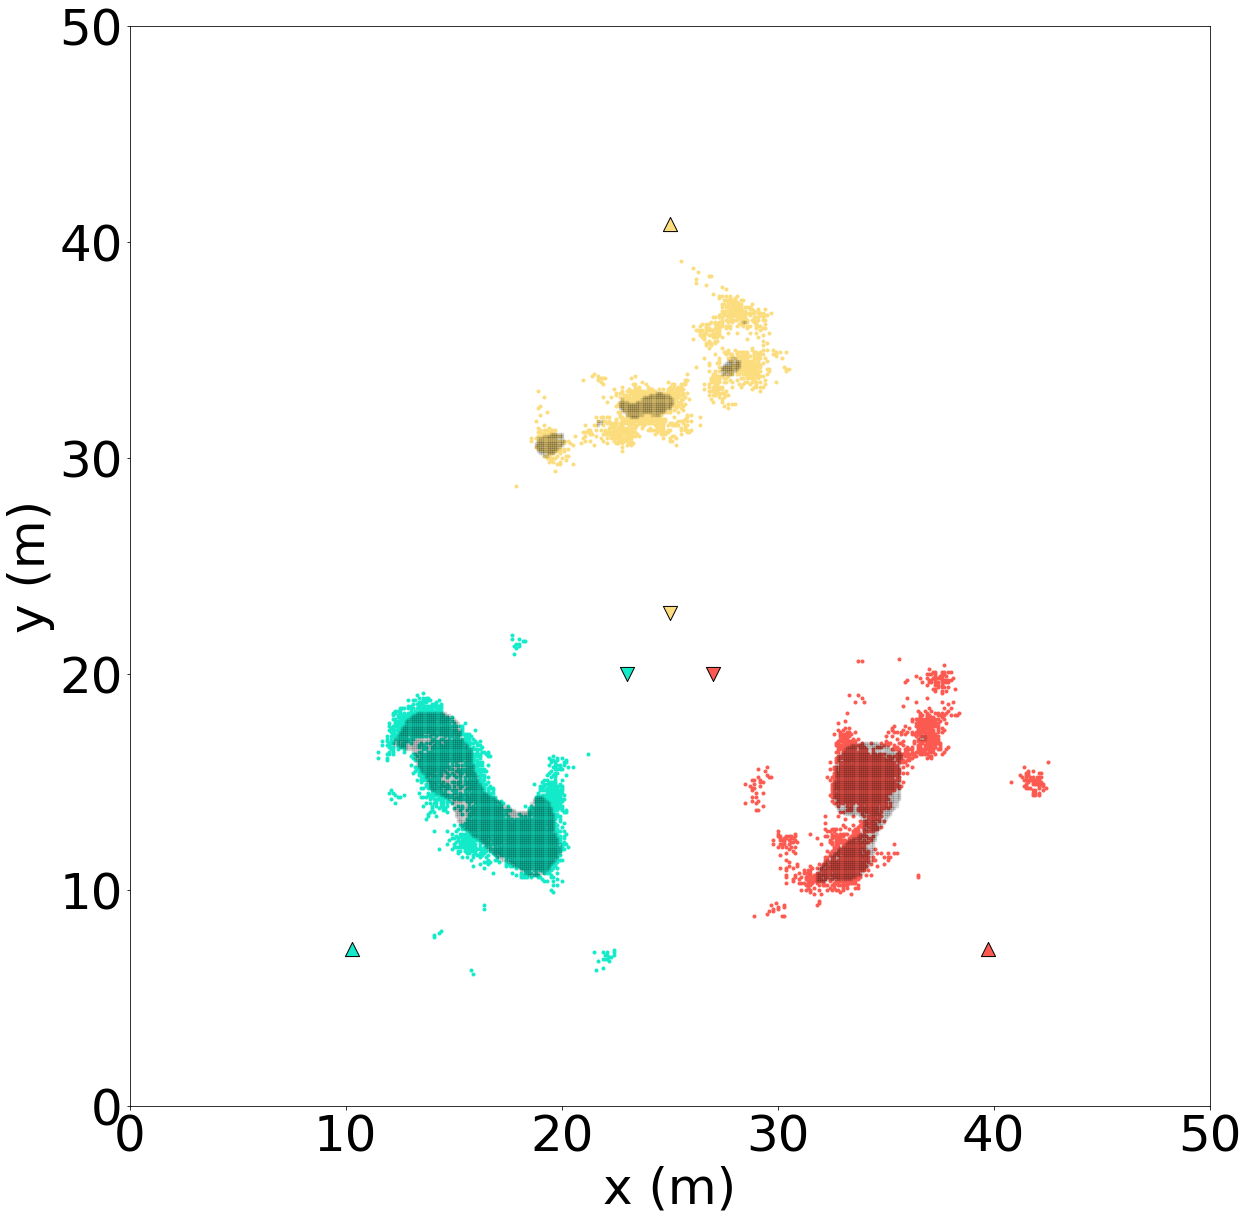

In [168]:
reload(sim)
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.gca().invert_yaxis()
plt.show()

In [169]:
reload(dtr)
els = [0.3/beta, 0.05/beta, 0.05/beta]
print(els)
dt_sys = dtr.DTR(pcs, region, els, beta, th=GAMMA_TH, p_th = p_th)

[4.8, 0.8, 0.8]
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
10 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
8 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 4 possibly non-convex polygons
8 total subregions


Total of 1 Permutations to Try
Working on Permutation (0, 1, 2)
Optimal Solution Improved to 48.98
Elapsed Time: 0.40


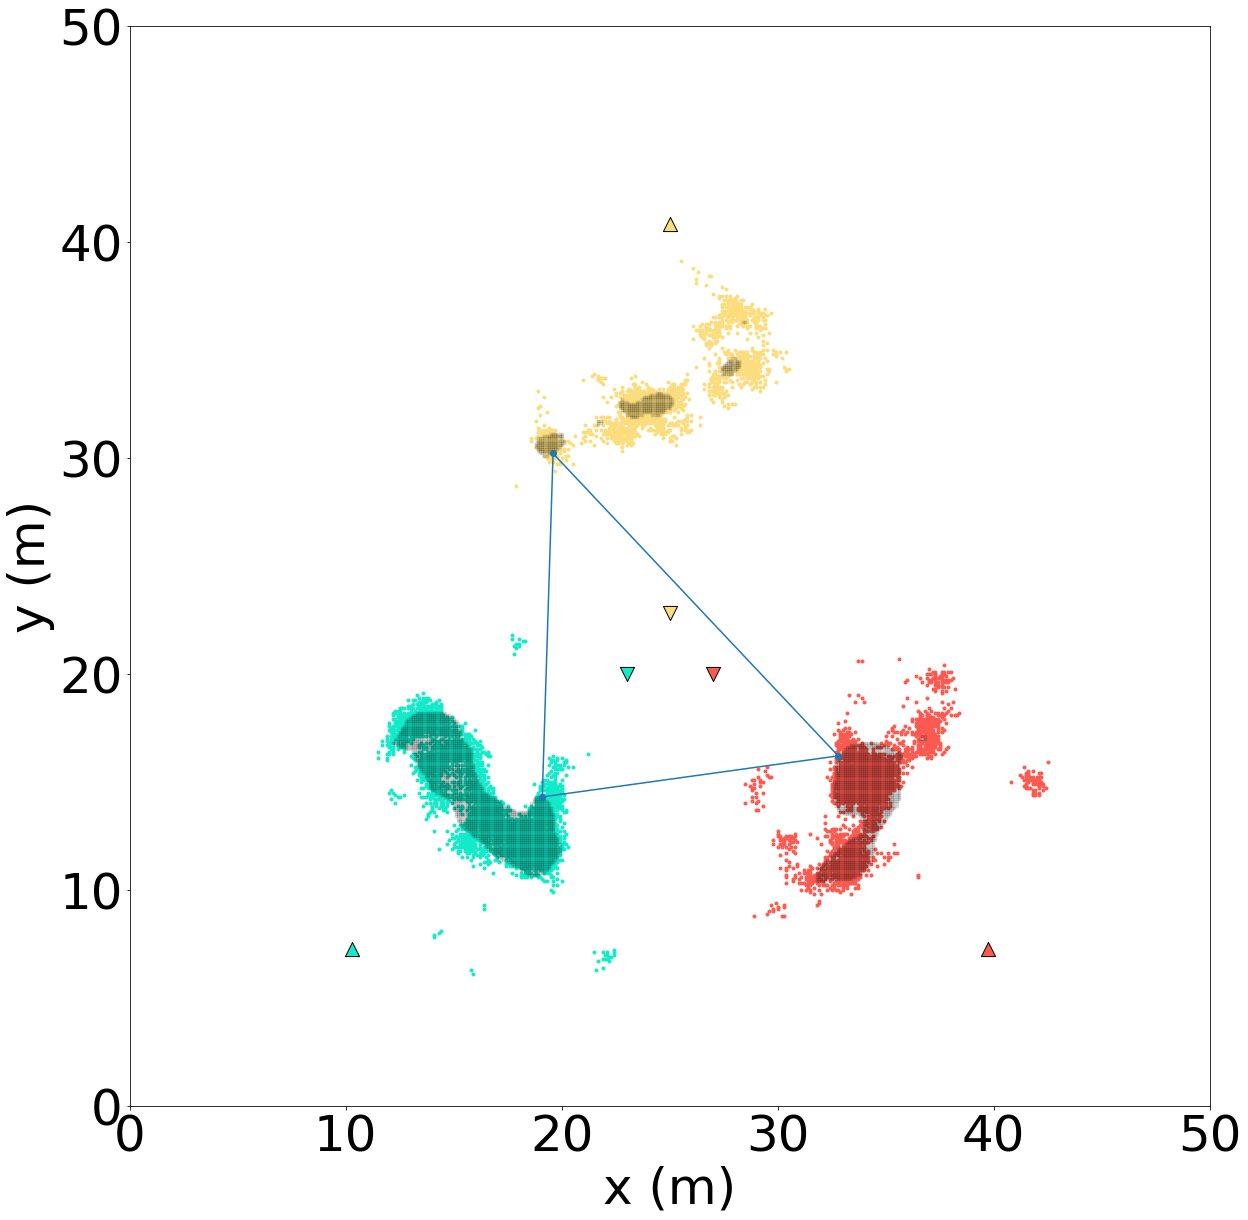

{'X': array([[19.1, 14.3],
        [32.8, 16.2],
        [19.6, 30.2]]),
 'SEQ': (0, 1, 2)}

In [170]:
regions = dt_sys.cregions
tspn_min, tspn_argmin = TSPN.TSPN_BF(regions)
x=tspn_argmin[0]

reload(sim)
order = list(tspn_argmin[1])
order.append(0)#complete the loop
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.plot(x[order,0], x[order,1], zorder=100)
plt.scatter(x[:,0], x[:,1], zorder = 100)
plt.gca().invert_yaxis()
plt.show()

TSPNP={'X':x, 'SEQ':tspn_argmin[1]}
TSPNP

In [171]:
v = 1
AORP = sim.calc_AORP(dt_sys, v)
hrs = 1
mins = 0
seconds = 0
print('Velocity = %f'%(v))
motion_power = motion.LinearMotionPower(7.2, 0.29, v)
sim.run_sims(dt_sys.ps, AORP, TSPNP, hrs, mins, seconds, motion_power, MOBILE_TX_POWER.W, v)
print('done')

/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
Optimized Waiting Time: 28.4906
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
Optimized Waiting Time: 27.2310
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
Optimized Waiting Time: 26.6066
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
Optimized Waiting Time: 26.6066
Velocity = 1.000000
Theotretical MB serviced: 23039.999999999996
Theoretical Energy Consumption (J): 16322.400000000003
	Th. WT	WT	E (J)	MBS	MBR
AORP	26.61	30.58	16433.76	22849.85	182.70
Tab	---	24.14	16451.04	22850.00	154.95
TSPN	---	31.03	16473.75	22788.55	201.65
done


In [172]:
pi = AORP['pi']
print(pi)
P = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        if i != j:
            P[i,j] = pi[j]
    P[i,:] /= sum(P[i,:])
print(P)
v, M = np.linalg.eig(P.T)
print(v)
print(M)
print(M[:,0]/sum(M[:,0]))

[0.99787563 0.00112437 0.001     ]
[[0.         0.52927228 0.47072772]
 [0.99899887 0.         0.00100113]
 [0.9988745  0.0011255  0.        ]]
[ 1.         -0.99894033 -0.00105967]
[[ 8.15742343e-01  8.16029571e-01 -8.81300894e-05]
 [ 4.32182476e-01 -4.31927222e-01 -7.07062712e-01]
 [ 3.84425205e-01 -3.84102349e-01  7.07150842e-01]]
[0.49973494 0.26476091 0.23550415]


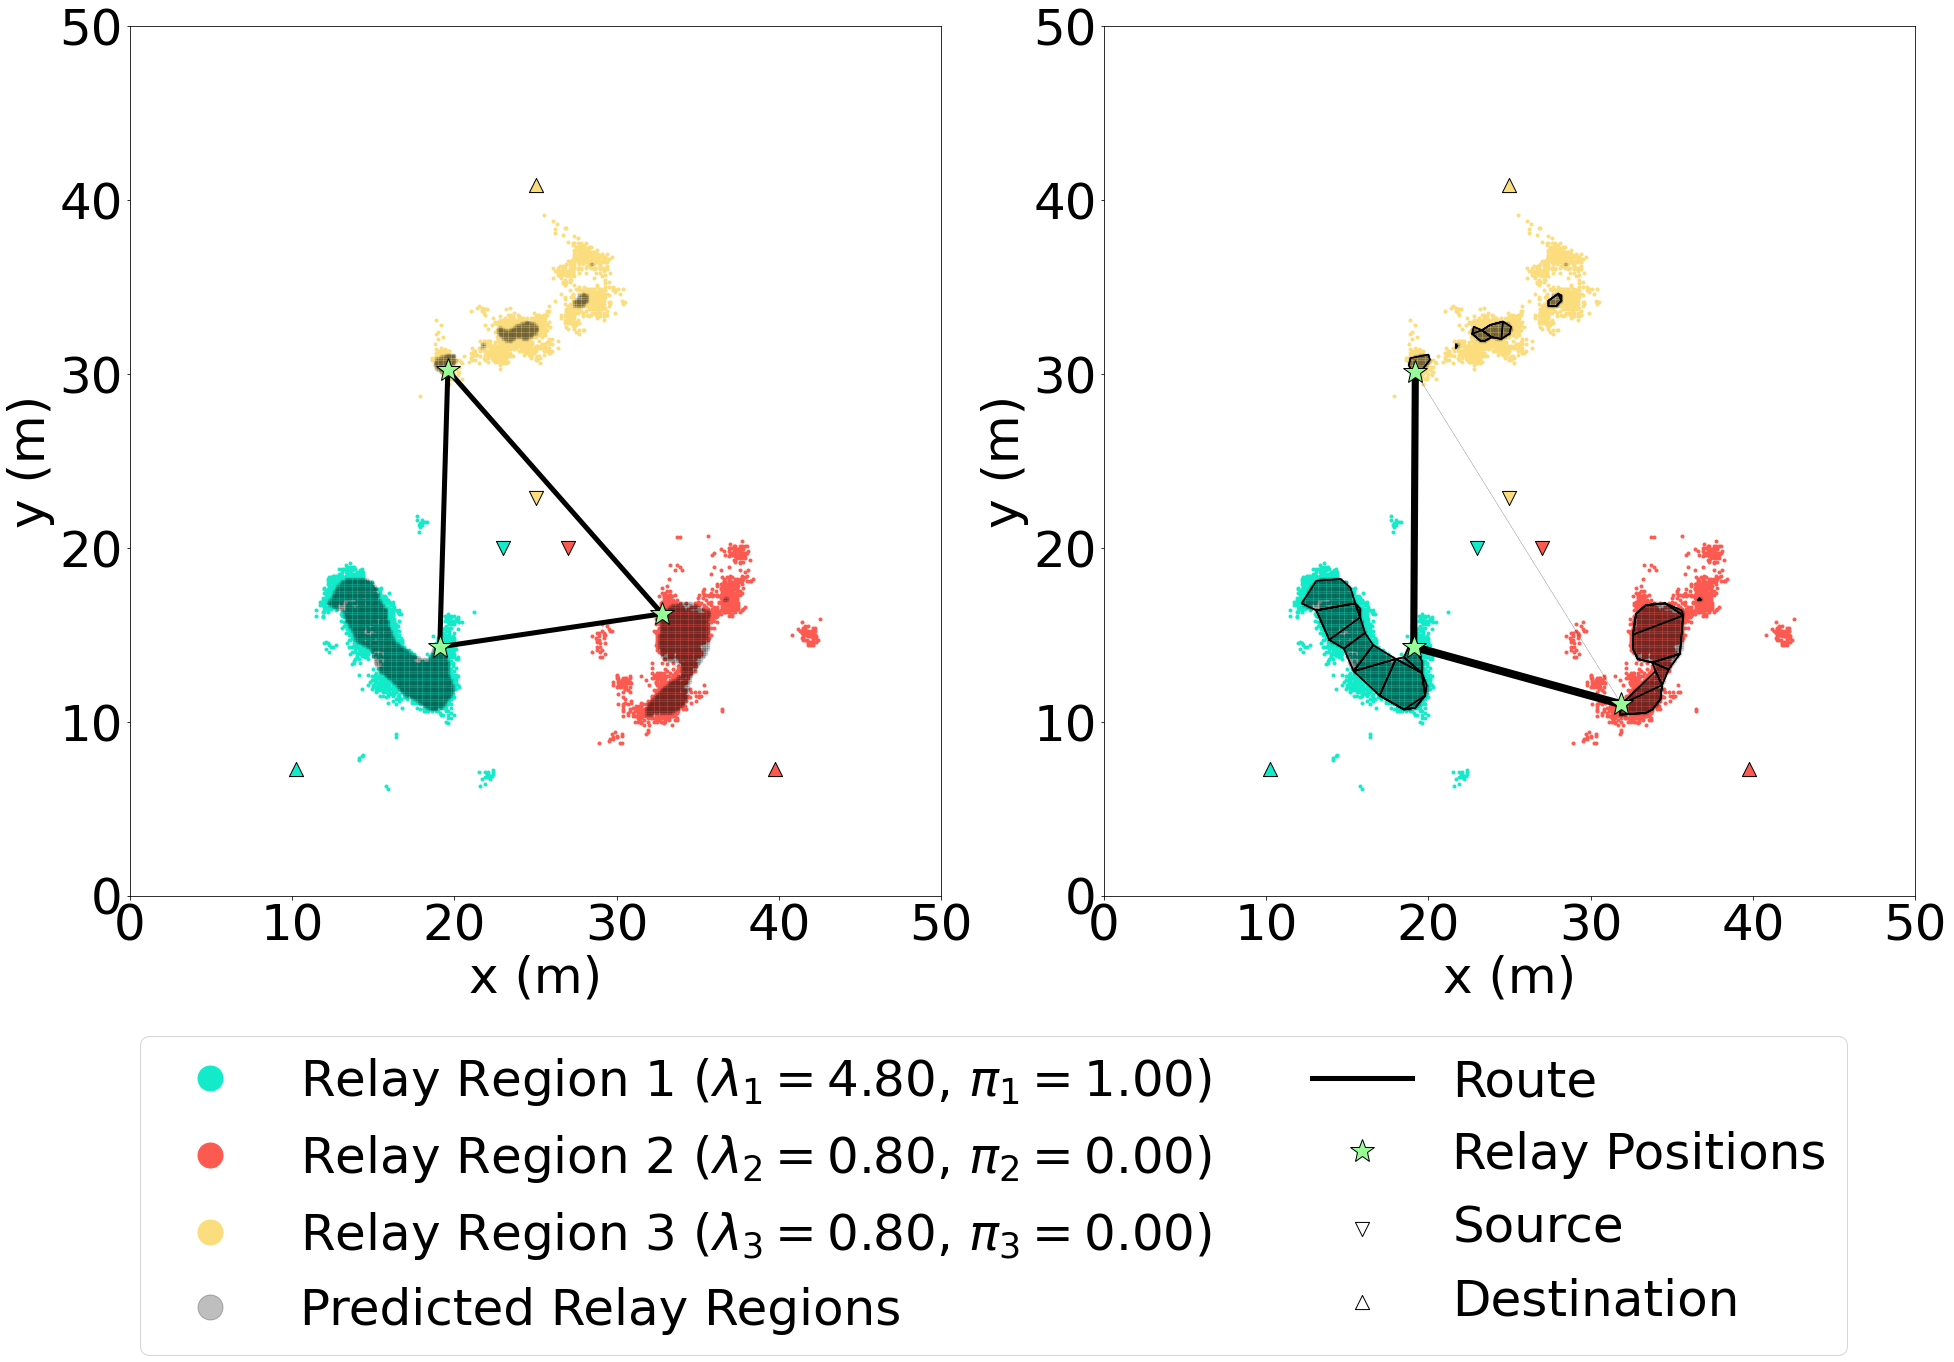

In [174]:
reload(sim)
sim.plot_AORP_W_TSPN(dt_sys, AORP, TSPNP, tjcps, pjcps, qBase, region, els, AORP['pi'])
sim.save_plt('tri_TSPNP_W_AORP.png')

In [135]:
%%notify

UsageError: Cell magic `%%notify` not found.
